In [279]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import time
import math

In [280]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [281]:
data = pd.read_csv("Data/area1.csv")

data.head()

,Date,Drought Level Index,Precipitation_in,Temperature_C,Vegetation,Evapotranspiration,County
0,2000-02,1.754260,0.32,25.557100,0.20440,1.640400,Crosby
1,2000-03,2.016075,3.07,26.973700,0.21600,2.716475,Crosby
2,2000-04,0.296925,2.36,33.351775,0.27375,1.790225,Crosby
3,2000-05,0.406600,1.02,40.815733,0.29960,1.057933,Crosby
4,2000-06,0.250000,4.55,36.667025,0.40450,3.800975,Crosby


In [282]:
X = data[['Precipitation_in','Temperature_C','Vegetation','Evapotranspiration']].copy()
# split feature and label
y = data['Drought Level Index'].copy()
len(X)

2367

In [283]:
# split training and test sets. 2367*0.8=1893.6
X_train = X[0:1894][:]
X_test = X[1894:][:]
y_train = y[0:1894]
y_test = y[1894:]

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [284]:
type(X_train)

numpy.ndarray

In [285]:
type(y_train)

pandas.core.series.Series

In [286]:
# convert to torch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
type(X_train)

torch.Tensor

In [287]:
# Define model
model = nn.Sequential(
    nn.Linear(in_features=4, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=1),
)

In [288]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [289]:
def train(model,loss_fn,optimizer,train_data,train_label,batch_size):
    train_loss = []
    start = 0
    for i in range(len(train_data) // batch_size):
        data = train_data[start:start+batch_size]
        label = train_label[start:start+batch_size]

        #Pass through Model
        train_out = model(data)

        #Get loss value
        loss = loss_fn(train_out,label.float())
        train_loss.append(float(loss.data.mean()))

        #Backpropagation    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        start += batch_size
    return train_loss

In [290]:
n_epochs = 300    # number of epochs to run
batch_size = 64
time_list = []
train_loss_list = []

for epoch in range(n_epochs):
    start_time = time.time()
    model = model.train()
    train_loss = train(model,loss_fn,optimizer,X_train,y_train,batch_size)
    train_loss_list.append(np.mean(train_loss))
    total_time = time.time() - start_time
    time_list.append(total_time)


C:\Users\mhe\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total training time: 3.274012565612793


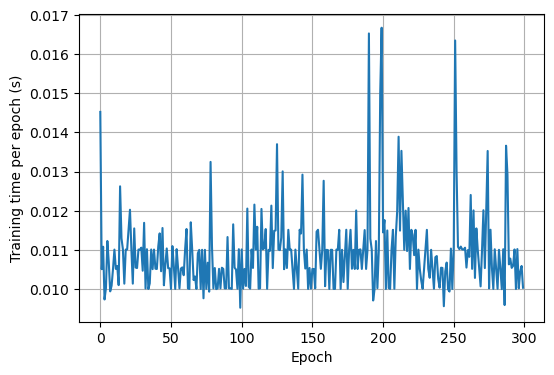

In [291]:
x = np.linspace(0.0, n_epochs-1, n_epochs)

print('Total training time:', sum(time_list))
plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.ylabel('Training time per epoch (s)')
plt.plot(x, time_list)
plt.grid()

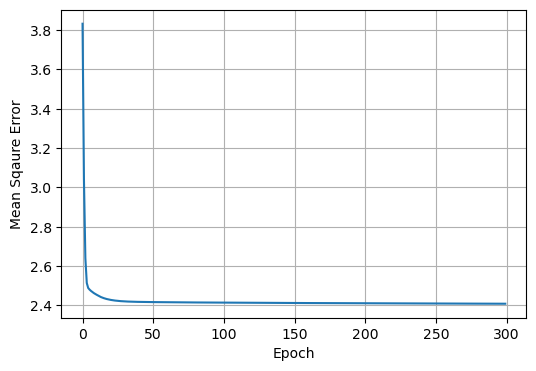

In [292]:
x = np.linspace(0.0, n_epochs-1, n_epochs)

plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.ylabel('Mean Sqaure Error')
plt.plot(x, train_loss_list)
plt.grid()

In [293]:
# evaluate trained model with test set
model = model.eval()
y_pred = model(X_test)
test_mse = loss_fn(y_pred, y_test)
print('MSE for test set:', test_mse)

MSE for test set: tensor(2.5872, grad_fn=<MseLossBackward0>)


C:\Users\mhe\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([473])) that is different to the input size (torch.Size([473, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


C:\Users\mhe\AppData\Local\Temp\ipykernel_25260\601584657.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred, dtype=torch.float32)


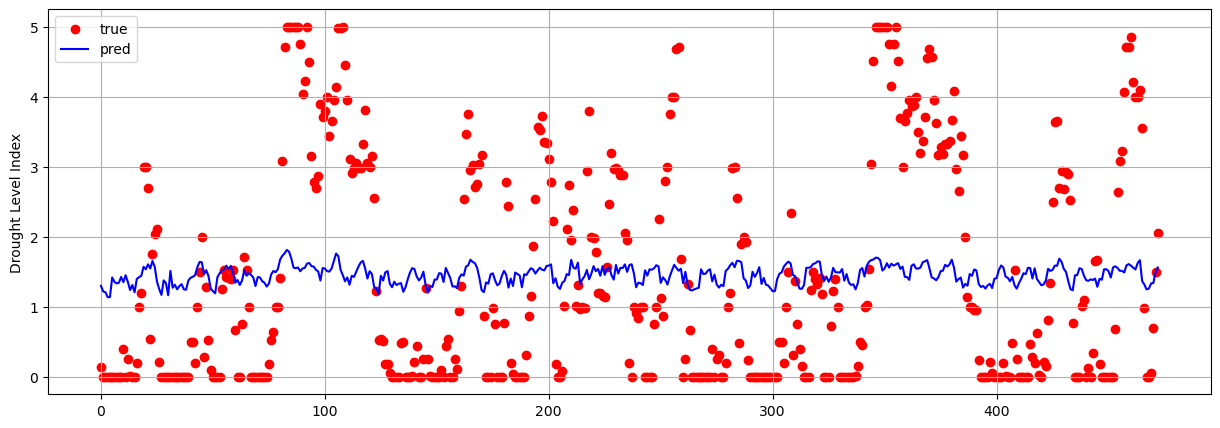

In [294]:
x = np.linspace(0.0, len(y_test)-1, len(y_test))
y_pred = torch.tensor(y_pred, dtype=torch.float32)
plt.figure(figsize=(15,5))
plt.scatter(x, y_test, label='true', color='red')
plt.plot(x, y_pred, label='pred', color='blue')
plt.ylabel('Drought Level Index')
plt.grid()
plt.legend()
plt.show()